<a href="https://colab.research.google.com/github/sazio/ATLAS_GSoC2021/blob/main/tutorials/W1D2_LinearDeepLearning/student/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Learning Hyperparameters
**Week 1, Day 2: Linear Deep Learning**

**By Neuromatch Academy**

__Content creators:__ Saeed Salehi, Andrew Saxe

__Content reviewers:__ Polina Turishcheva, Antoine De Comite, Kelson Shilling-Scrivo

__Content editors:__ Anoop Kulkarni

__Production editors:__ Khalid Almubarak, Spiros Chavlis


**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

* Training landscape
* The effect of depth
* Choosing a learning rate
* Initialization matters


In [10]:
# @title Tutorial slides

# @markdown These are the slides for the videos in the tutorial
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/sne2m/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

This a GPU-Free tutorial!

In [11]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm

In [12]:
# Imports
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [13]:
# @title Figure settings

from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import HBox, interactive_output, ToggleButton, Layout
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [14]:
# @title Plotting functions

def plot_x_y_(x_t_, y_t_, x_ev_, y_ev_, loss_log_, weight_log_):
  """
  """
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.scatter(x_t_, y_t_, c='r', label='training data')
  plt.plot(x_ev_, y_ev_, c='b', label='test results', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.subplot(1, 3, 2)
  plt.plot(loss_log_, c='r')
  plt.xlabel('epochs')
  plt.ylabel('mean squared error')
  plt.subplot(1, 3, 3)
  plt.plot(weight_log_)
  plt.xlabel('epochs')
  plt.ylabel('weights')
  plt.show()


def plot_vector_field(what, init_weights=None):
  """
  """
  n_epochs=40
  lr=0.15
  x_pos = np.linspace(2.0, 0.5, 100, endpoint=True)
  y_pos = 1. / x_pos
  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  cmap = matplotlib.cm.plasma
  plt.figure(figsize=(8, 7))
  ax = plt.gca()

  if what == 'all' or what == 'vectors':
    for i, a in enumerate(x):
      for j, b in enumerate(y):
        temp_model = ShallowNarrowLNN([a, b])
        da, db = temp_model.dloss_dw(x_temp, y_temp)
        zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)
        scale = min(40 * np.sqrt(da**2 + db**2), 50)
        ax.quiver(a, b, - da, - db, scale=scale, color=cmap(np.sqrt(da**2 + db**2)))

  if what == 'all' or what == 'trajectory':
    if init_weights is None:
      for init_weights in [[0.5, -0.5], [0.55, -0.45], [-1.8, 1.7]]:
        temp_model = ShallowNarrowLNN(init_weights)
        _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
        ax.scatter(temp_records[:, 0], temp_records[:, 1],
                    c=np.arange(len(temp_records)), cmap='Greys')
        ax.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
        ax.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)
    else:
      temp_model = ShallowNarrowLNN(init_weights)
      _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
      ax.scatter(temp_records[:, 0], temp_records[:, 1],
                  c=np.arange(len(temp_records)), cmap='Greys')
      ax.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
      ax.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)

  if what == 'all' or what == 'loss':
    contplt = ax.contourf(x, y, np.log(zz+0.001), zorder=-1, cmap='coolwarm', levels=100)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contplt, cax=cax)
    cbar.set_label('log (Loss)')

  ax.set_xlabel("$w_1$")
  ax.set_ylabel("$w_2$")
  ax.set_xlim(-1.9, 1.9)
  ax.set_ylim(-1.9, 1.9)

  plt.show()


def plot_loss_landscape():
  """
  """
  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  for i, a in enumerate(x):
    for j, b in enumerate(y):
      temp_model = ShallowNarrowLNN([a, b])
      zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)

  temp_model = ShallowNarrowLNN([-1.8, 1.7])
  loss_rec_1, w_rec_1 = temp_model.train(x_temp, y_temp, 0.02, 240)

  temp_model = ShallowNarrowLNN([1.5, -1.5])
  loss_rec_2, w_rec_2 = temp_model.train(x_temp, y_temp, 0.02, 240)

  plt.figure(figsize=(12, 8))
  ax = plt.subplot(1, 1, 1, projection='3d')
  ax.plot_surface(xx, yy, np.log(zz+0.5), cmap='coolwarm', alpha=0.5)
  ax.scatter3D(w_rec_1[:, 0], w_rec_1[:, 1], np.log(loss_rec_1+0.5),
                c='k', s=50, zorder=9)
  ax.scatter3D(w_rec_2[:, 0], w_rec_2[:, 1], np.log(loss_rec_2+0.5),
                c='k', s=50, zorder=9)
  plt.axis("off")
  ax.view_init(45, 260)

  plt.show()


def depth_widget(depth):
  if depth == 0:
    depth_lr_init_interplay(depth, 0.02, 0.9)
  else:
    depth_lr_init_interplay(depth, 0.01, 0.9)


def lr_widget(lr):
  depth_lr_init_interplay(50, lr, 0.9)


def depth_lr_interplay(depth, lr):
  depth_lr_init_interplay(depth, lr, 0.9)


def depth_lr_init_interplay(depth, lr, init_weights):
  n_epochs = 600

  x_train, y_train = gen_samples(100, 2.0, 0.1)
  model = DeepNarrowLNN(np.full((1, depth+1), init_weights))

  plt.figure(figsize=(10, 5))
  plt.plot(model.train(x_train, y_train, lr, n_epochs),
            linewidth=3.0, c='m')

  plt.title("Training a {}-layer LNN with"
  " $\eta=${} initialized with $w_i=${}".format(depth, lr, init_weights), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.ylim(0.001, 1.0)
  plt.show()


def plot_init_effect():
  depth = 15
  n_epochs = 250
  lr = 0.02

  x_train, y_train = gen_samples(100, 2.0, 0.1)

  plt.figure(figsize=(12, 6))
  for init_w in np.arange(0.7, 1.09, 0.05):
      model = DeepNarrowLNN(np.full((1, depth), init_w))
      plt.plot(model.train(x_train, y_train, lr, n_epochs),
              linewidth=3.0, label="initial weights {:.2f}".format(init_w))
  plt.title("Training a {}-layer narrow LNN with $\eta=${}".format(depth, lr), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.legend(loc='lower left', ncol=4)
  plt.ylim(0.001, 1.0)
  plt.show()


class InterPlay:
  def __init__(self):
    self.lr = [None]
    self.depth = [None]
    self.success = [None]
    self.min_depth, self.max_depth = 5, 65
    self.depth_list = np.arange(10, 61, 10)
    self.i_depth = 0
    self.min_lr, self.max_lr = 0.001, 0.105
    self.n_epochs = 600
    self.x_train, self.y_train = gen_samples(100, 2.0, 0.1)
    self.converged = False
    self.button = None
    self.slider = None

  def train(self, lr, update=False, init_weights=0.9):
    if update and self.converged and self.i_depth < len(self.depth_list):
      depth = self.depth_list[self.i_depth]
      self.plot(depth, lr)
      self.i_depth += 1
      self.lr.append(None)
      self.depth.append(None)
      self.success.append(None)
      self.converged = False
      self.slider.value = 0.005
      if self.i_depth < len(self.depth_list):
        self.button.value = False
        self.button.description = 'Explore!'
        self.button.disabled = True
        self.button.button_style = 'danger'
      else:
        self.button.value = False
        self.button.button_style = ''
        self.button.disabled = True
        self.button.description = 'Done!'
      time.sleep(1.0)

    elif self.i_depth < len(self.depth_list):
      depth = self.depth_list[self.i_depth]
      # assert self.min_depth <= depth <= self.max_depth
      assert self.min_lr <= lr <= self.max_lr
      self.converged = False

      model = DeepNarrowLNN(np.full((1, depth), init_weights))
      self.losses = np.array(model.train(self.x_train, self.y_train, lr, self.n_epochs))
      if np.any(self.losses < 1e-2):
        success = np.argwhere(self.losses < 1e-2)[0][0]
        if np.all((self.losses[success:] < 1e-2)):
          self.converged = True
          self.success[-1] = success
          self.lr[-1] = lr
          self.depth[-1] = depth
          self.button.disabled = False
          self.button.button_style = 'success'
          self.button.description = 'Register!'
        else:
          self.button.disabled = True
          self.button.button_style = 'danger'
          self.button.description = 'Explore!'
      else:
        self.button.disabled = True
        self.button.button_style = 'danger'
        self.button.description = 'Explore!'
      self.plot(depth, lr)

  def plot(self, depth, lr):
    fig = plt.figure(constrained_layout=False, figsize=(10, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    ax1.plot(self.losses, linewidth=3.0, c='m')
    ax1.set_title("Training a {}-layer LNN with"
    " $\eta=${}".format(depth, lr), pad=15, fontsize=16)
    ax1.set_yscale('log')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Log mean squared error')
    ax1.set_ylim(0.001, 1.0)

    ax2.set_xlim(self.min_depth, self.max_depth)
    ax2.set_ylim(-10, self.n_epochs)
    ax2.set_xlabel('Depth')
    ax2.set_ylabel('Learning time (Epochs)')
    ax2.set_title("Learning time vs depth", fontsize=14)
    ax2.scatter(np.array(self.depth), np.array(self.success), c='r')

    # ax3.set_yscale('log')
    ax3.set_xlim(self.min_depth, self.max_depth)
    ax3.set_ylim(self.min_lr, self.max_lr)
    ax3.set_xlabel('Depth')
    ax3.set_ylabel('Optimial learning rate')
    ax3.set_title("Empirically optimal $\eta$ vs depth", fontsize=14)
    ax3.scatter(np.array(self.depth), np.array(self.lr), c='r')

    plt.show()

In [15]:
# @title Helper functions

atform = AirtableForm('appn7VdPRseSoMXEG','W1D2_T2','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')


def gen_samples(n, a, sigma):
  """
  Generates `n` samples with `y = z * x + noise(sgma)` linear relation.

  Args:
    n : int
    a : float
    sigma : float
  Retutns:
   x : np.array
   y : np.array
  """
  assert n > 0
  assert sigma >= 0

  if sigma > 0:
    x = np.random.rand(n)
    noise = np.random.normal(scale=sigma, size=(n))
    y = a * x + noise
  else:
    x = np.linspace(0.0, 1.0, n, endpoint=True)
    y = a * x
  return x, y


class ShallowNarrowLNN:
  """
  Shallow and narrow (one neuron per layer) linear neural network
  """
  def __init__(self, init_ws):
    """
    init_ws: initial weights as a list
    """
    assert isinstance(init_ws, list)
    assert len(init_ws) == 2
    self.w1 = init_ws[0]
    self.w2 = init_ws[1]

  def forward(self, x):
    """
    The forward pass through netwrok y = x * w1 * w2
    """
    y = x * self.w1 * self.w2
    return y

  def loss(self, y_p, y_t):
    """
    Mean squared error (L2) with 1/2 for convenience
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2).mean()
    return mse

  def dloss_dw(self, x, y_t):
    """
    partial derivative of loss with respect to weights

    Args:
      x : np.array
      y_t : np.array
    """
    assert x.shape == y_t.shape
    Error = y_t - self.w1 * self.w2 * x
    dloss_dw1 = - (2 * self.w2 * x * Error).mean()
    dloss_dw2 = - (2 * self.w1 * x * Error).mean()
    return dloss_dw1, dloss_dw2

  def train(self, x, y_t, eta, n_ep):
    """
    Gradient descent algorithm

    Args:
      x : np.array
      y_t : np.array
      eta: float
      n_ep : int
    """
    assert x.shape == y_t.shape

    loss_records = np.empty(n_ep)  # pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

    for i in range(n_ep):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_p, y_t)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
      self.w1 -= eta * dloss_dw1
      self.w2 -= eta * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


class DeepNarrowLNN:
  """
  Deep but thin (one neuron per layer) linear neural network
  """
  def __init__(self, init_ws):
    """
    init_ws: initial weights as a numpy array
    """
    self.n = init_ws.size
    self.W = init_ws.reshape(1, -1)

  def forward(self, x):
    """
    x : np.array
      input features
    """
    y = np.prod(self.W) * x
    return y

  def loss(self, y_t, y_p):
    """
    mean squared error (L2 loss)

    Args:
      y_t : np.array
      y_p : np.array
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2 / 2).mean()
    return mse

  def dloss_dw(self, x, y_t, y_p):
    """
    analytical gradient of weights

    Args:
      x : np.array
      y_t : np.array
      y_p : np.array
    """
    E = y_t - y_p  # = y_t - x * np.prod(self.W)
    Ex = np.multiply(x, E).mean()
    Wp = np.prod(self.W) / (self.W + 1e-9)
    dW = - Ex * Wp
    return dW

  def train(self, x, y_t, eta, n_epochs):
    """
    training using gradient descent

    Args:
      x : np.array
      y_t : np.array
      eta: float
      n_epochs : int
    """
    loss_records = np.empty(n_epochs)
    loss_records[:] = np.nan
    for i in range(n_epochs):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_t, y_p).mean()
      dloss_dw = self.dloss_dw(x, y_t, y_p)
      if np.isnan(dloss_dw).any() or np.isinf(dloss_dw).any():
        return loss_records
      self.W -= eta * dloss_dw
    return loss_records

In [16]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [17]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [18]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


---
# Section 1: A Shallow Narrow Linear Neural Network

*Time estimate: ~30 mins*

In [19]:
# @title Video 1: Shallow Narrow Linear Net
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1F44y117ot", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"6e5JIYsqVvU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('video 1: Shallow Narrow Linear Net')

display(out)

## Section 1.1: A Shallow Narrow Linear Net

To better understand the behavior of neural network training with gradient descent, we start with the incredibly simple case of a shallow narrow linear neural net, since state-of-the-art models are impossible to dissect and comprehend with our current mathematical tools.

The model we use has one hidden layer, with only one neuron, and two weights. We consider the squared error (or L2 loss) as the cost function. As you may have already guessed, we can visualize the model as a neural network:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/shallow_narrow_nn.png" width="400"/></center>

<br/>

or by its computation graph:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/shallow_narrow.png" alt="Shallow Narrow Graph" width="400"/></center>

or on a rare occasion, even as a reasonably compact mapping:

$$ loss = (y - w_1 \cdot w_2 \cdot x)^2 $$

<br/>

Implementing a neural network from scratch without using any Automatic Differentiation tool is rarely necessary. The following two exercises are therefore **Bonus** (optional) exercises. Please ignore them if you have any time-limits or pressure and continue to Section 1.2.

### Analytical Exercise 1.1: Loss Gradients (Optional)

Once again, we ask you to calculate the network gradients analytically, since you will need them for the next exercise. We understand how annoying this is.

$\dfrac{\partial{loss}}{\partial{w_1}} = ?$

$\dfrac{\partial{loss}}{\partial{w_2}} = ?$

<br/>

---
#### Solution

$\dfrac{\partial{loss}}{\partial{w_1}} = -2 \cdot w_2 \cdot x \cdot (y - w_1 \cdot w_2 \cdot x)$

$\dfrac{\partial{loss}}{\partial{w_2}} = -2 \cdot w_1 \cdot x \cdot (y - w_1 \cdot w_2 \cdot x)$

---


### Coding Exercise 1.1: Implement simple narrow LNN (Optional)

Next, we ask you to implement the `forward` pass for our model from scratch without using PyTorch.

Also, although our model gets a single input feature and outputs a single prediction, we could calculate the loss and perform training for multiple samples at once. This is the common practice for neural networks, since computers are incredibly fast doing matrix (or tensor) operations on batches of data, rather than processing samples one at a time through `for` loops. Therefore, for the `loss` function, please implement the **mean** squared error (MSE), and adjust your analytical gradients accordingly when implementing the `dloss_dw` function.

Finally, complete the `train` function for the gradient descent algorithm:

\begin{equation}
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla loss (\mathbf{w}^{(t)})
\end{equation}

Random seed 2021 has been set.


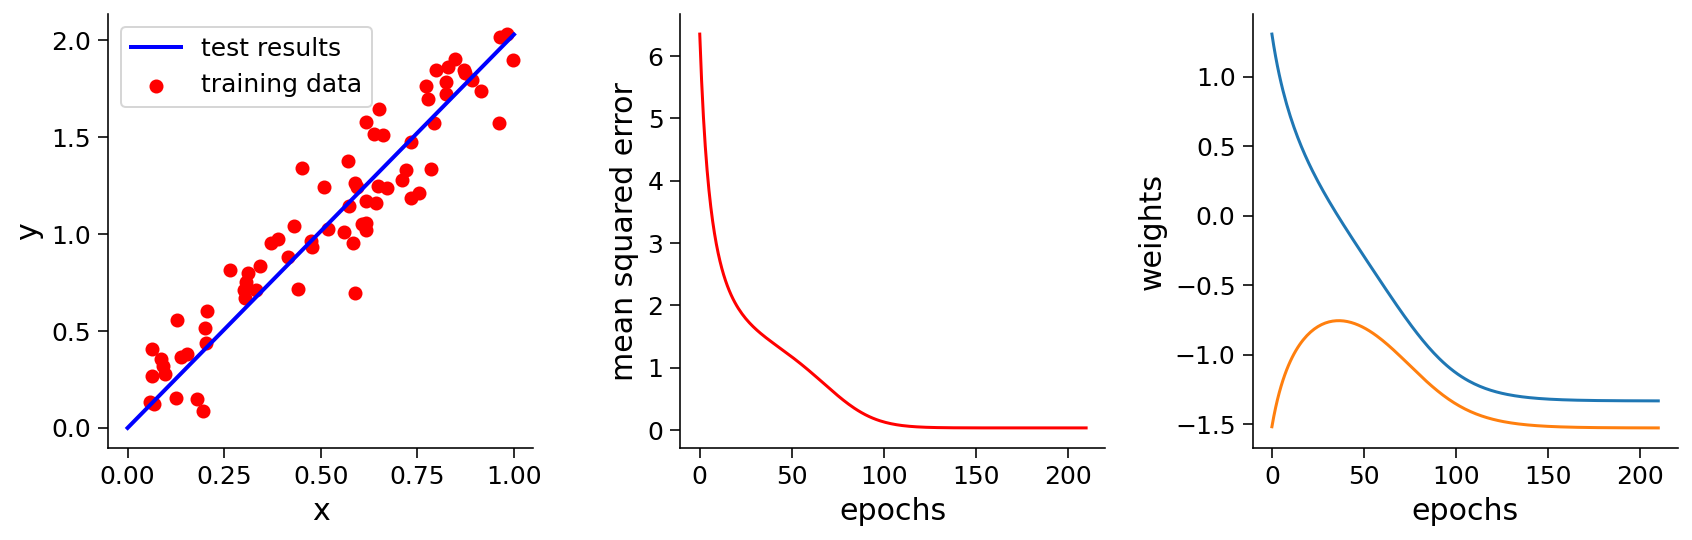

In [30]:
class ShallowNarrowExercise:
  """Shallow and narrow (one neuron per layer) linear neural network
  """
  def __init__(self, init_weights):
    """
    Args:
      init_weights (list): initial weights
    """
    assert isinstance(init_weights, (list, np.ndarray, tuple))
    assert len(init_weights) == 2
    self.w1 = init_weights[0]
    self.w2 = init_weights[1]


  def forward(self, x):
    """The forward pass through netwrok y = x * w1 * w2
    Args:
      x (np.ndarray): features (inputs) to neural net
    returns:
      (np.ndarray): neural network output (prediction)
    """
    y = x * self.w1 * self.w2
    return y


  def dloss_dw(self, x, y_true):
    """Gradient of loss with respect to weights
    Args:
      x (np.ndarray): features (inputs) to neural net
      y_true (np.ndarray): true labels
    returns:
      (float): mean gradient of loss with respect to w1
      (float): mean gradient of loss with respect to w2
    """
    assert x.shape == y_true.shape
    dloss_dw1 = - (2 * self.w2 * x * (y_true - self.w1 * self.w2 * x)).mean()
    dloss_dw2 = - (2 * self.w1 * x * (y_true - self.w1 * self.w2 * x)).mean()
    return dloss_dw1, dloss_dw2


  def train(self, x, y_true, lr, n_ep):
    """Training with Gradient descent algorithm
    Args:
      x (np.ndarray): features (inputs) to neural net
      y_true (np.ndarray): true labels
      lr (float): learning rate
      n_ep (int): number of epochs (training iterations)
    returns:
      (list): training loss records
      (list): training weight records (evolution of weights)
    """
    assert x.shape == y_true.shape

    loss_records = np.empty(n_ep)  # pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

    for i in range(n_ep):
      y_prediction = self.forward(x)
      loss_records[i] = loss(y_prediction, y_true)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_true)
      self.w1 -= lr * dloss_dw1
      self.w2 -= lr * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


def loss(y_prediction, y_true):
  """Mean squared error
  Args:
    y_prediction (np.ndarray): model output (prediction)
    y_true (np.ndarray): true label
  returns:
    (np.ndarray): mean squared error loss
  """
  assert y_prediction.shape == y_true.shape
  mse = ((y_true - y_prediction)**2).mean()
  return mse

#add event to airtable
atform.add_event('Coding Exercise 1.1: Implement simple narrow LNN')


set_seed(seed=SEED)
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)
## Uncomment to run
sn_model = ShallowNarrowExercise(initial_weights)
loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval = sn_model.forward(x_eval)

plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial2_Solution_46492cd6.py)

*Example output:*

<img alt='Solution hint' align='left' width=1696.0 height=544.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/W1D2_Tutorial2_Solution_46492cd6_1.png>



## Section 1.2: Learning landscapes

In [31]:
# @title Video 2: Training Landscape
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Nv411J71X", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"k28bnNAcOEg", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 2: Training Landscape')

display(out)

As you may have already asked yourself, we can analytically find $w_1$ and $w_2$ without using gradient descent:

\begin{equation}
w_1 \cdot w_2 = \dfrac{y}{x}
\end{equation}

In fact, we can plot the gradients, the loss function and all the possible solutions in one figure. In this example, we use the $y = 1x$ mapping:

**Blue ribbon**: shows all possible solutions: $~ w_1 w_2 = \dfrac{y}{x} = \dfrac{x}{x} = 1 \Rightarrow w_1 = \dfrac{1}{w_2}$

**Contour background**: Shows the loss values, red being higher loss

**Vector field (arrows)**: shows the gradient vector field. The larger yellow arrows show larger gradients, which correspond to bigger steps by gradient descent.

**Scatter circles**: the trajectory (evolution) of weights during training for three different initializations, with blue dots marking the start of training and red crosses ( **x** ) marking the end of training. You can also try your own initializations (keep the initial values between `-2.0` and `2.0`) as shown here:
```python
plot_vector_field('all', [1.0, -1.0])
```

Finally, if the plot is too crowded, feel free to pass one of the following strings as argument:

```python
plot_vector_field('vectors')  # for vector field
plot_vector_field('trajectory')  # for training trajectory
plot_vector_field('loss')  # for loss contour
```

**Think!**

Explore the next two plots. Try different initial values.  Can you find the saddle point? Why does training slow down near the minima?

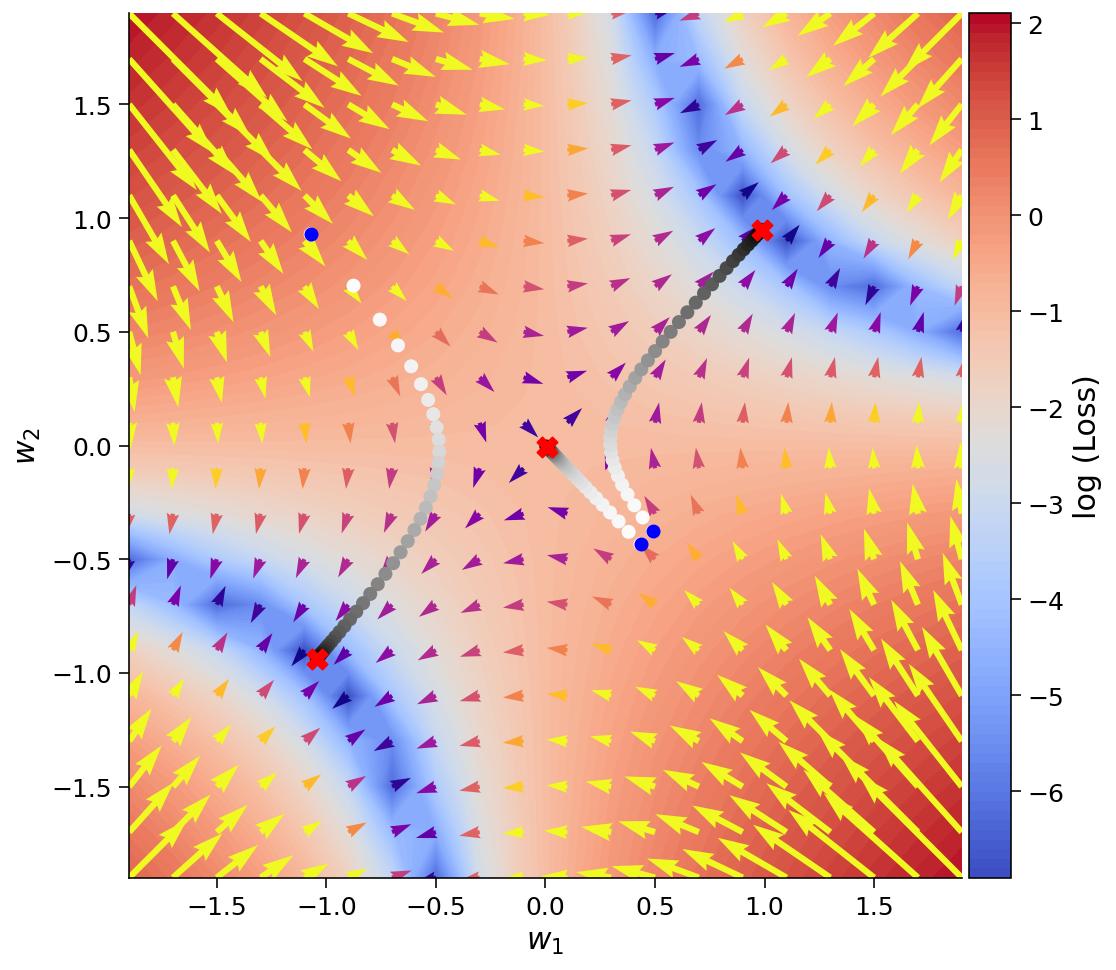

In [32]:
plot_vector_field('all')

Here, we also visualize the loss landscape in a 3-D plot, with two training trajectories for different initial conditions.
Note: the trajectories from the 3D plot and the previous plot are independent and different.

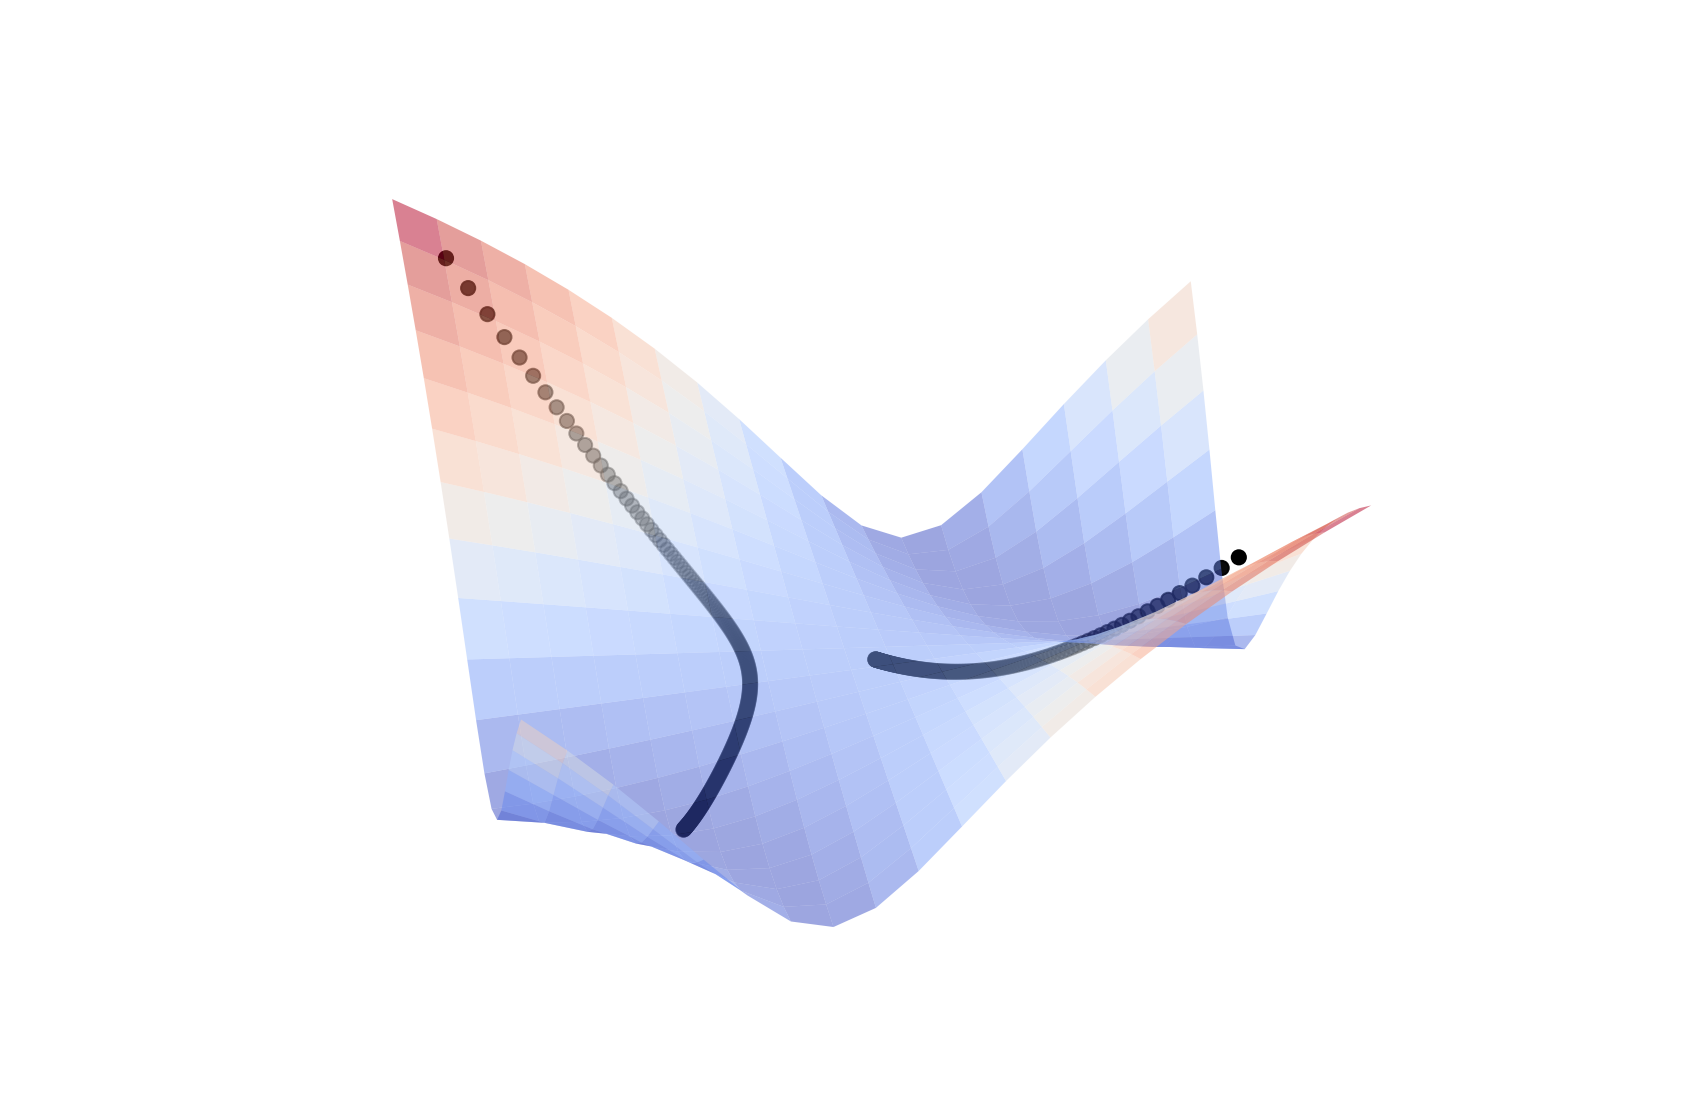

In [33]:
plot_loss_landscape()

In [34]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
    value='Type your here and Push submit',
    placeholder='Type something',
    description='',
    disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
    atform.add_answer('q1', text.value)
    print("Submission successful!")

button.on_click(on_button_clicked)

Textarea(value='Type your here and Push submit', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Submission successful!


In [50]:
# @title Video 3: Training Landscape - Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1py4y1j7cv", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"0EcUGgxOdkI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 3: Training Landscape - Discussiond')

display(out)

---
# Section 2: Depth, Learning rate, and initialization
*Time estimate: ~45 mins*

Successful deep learning models are often developed by a team of very clever people, spending many many hours "tuning" learning hyperparameters, and finding effective initializations. In this section, we look at three basic (but often not simple) hyperparameters: depth, learning rate, and initialization.

## Section 2.1: The effect of depth

In [49]:
# @title Video 4: Effect of Depth
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1z341167di", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Ii_As9cRR5Q", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 4: Effect of Depth')

display(out)

Why might depth be useful? What makes a network or learning system "deep"? The reality is that shallow neural nets are often incapable of learning complex functions due to data limitations. On the other hand, depth seems like magic. Depth can change the functions a network can represent, the way a network learns, and how a network generalizes to unseen data. 

So let's look at the challenges that depth poses in training a neural network. Imagine a single input, single output linear network with 50 hidden layers and only one neuron per layer (i.e. a narrow deep neural network). The output of the network is easy to calculate:

$$ prediction = x \cdot w_1 \cdot w_2 \cdot \cdot \cdot w_{50} $$

If the initial value for all the weights is $w_i = 2$, the prediction for $x=1$ would be **exploding**: $y_p = 2^{50} \approx 1.1256 \times 10^{15}$. On the other hand, for weights initialized to $w_i = 0.5$, the output is **vanishing**: $y_p = 0.5^{50} \approx 8.88 \times 10^{-16}$. Similarly, if we recall the chain rule, as the graph gets deeper, the number of elements in the chain multiplication increases, which could lead to exploding or vanishing gradients. To avoid such numerical vulnerablities that could impair our training algorithm, we need to understand the effect of depth.


### Interactive Demo 2.1: Depth widget

Use the widget to explore the impact of depth on the training curve (loss evolution) of a deep but narrow neural network.

**Think!**

Which networks trained the fastest? Did all networks eventually "work" (converge)? What is the shape of their learning trajectory?

In [43]:
# @markdown Make sure you execute this cell to enable the widget!

_ = interact(depth_widget,
    depth = IntSlider(min=0, max=51,
                      step=5, value=0,
                      continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=51, step=5), Output…

In [44]:
# @title Video 5: Effect of Depth - Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Qq4y1H7uk", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"EqSDkwmSruk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 5: Effect of Depth - Discussion')

display(out)

## Section 2.2: Choosing a learning rate

The learning rate is a common hyperparameter for most optimization algorithms. How should we set it? Sometimes the only option is to try all the possibilities, but sometimes knowing some key trade-offs will help guide our search for good hyperparameters.

In [42]:
# @title Video 6: Learning Rate
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV11f4y157MT", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"w_GrCVM-_Qo", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 6: Learning Rate')

display(out)

### Interactive Demo 2.2: Learning rate widget

Here, we fix the network depth to 50 layers. Use the widget to explore the impact of learning rate $\eta$ on the training curve (loss evolution) of a deep but narrow neural network.

**Think!**

Can we say that larger learning rates always lead to faster learning? Why not? 

In [40]:
# @markdown Make sure you execute this cell to enable the widget!

_ = interact(lr_widget,
    lr = FloatSlider(min=0.005, max=0.045, step=0.005, value=0.005,
                     continuous_update=False, readout_format='.3f',
                     description='eta'))

interactive(children=(FloatSlider(value=0.005, continuous_update=False, description='eta', max=0.045, min=0.00…

In [41]:
# @title Video 7: Learning Rate - Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Aq4y1p7bh", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"cmS0yqImz2E", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 7: Learning Rate - Discussion')

display(out)

## Section 2.3: Depth vs Learning Rate

In [39]:
# @title Video 8: Depth and Learning Rate
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1V44y1177e", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"J30phrux_3k", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 8: Depth and Learning Rate')

display(out)

### Interactive Demo 2.3: Depth and Learning-Rate


**Important instruction**
The exercise starts with 10 hidden layers. Your task is to find the learning rate that delivers fast but robust convergence (learning). When you are confident about the learning rate, you can **Register** the optimal learning rate for the given depth. Once you press register, a deeper model is instantiated, so you can find the next optimal learning rate. The Register button turns green only when the training converges, but does not imply the fastest convergence. Finally, be patient :) the widgets are slow.


**Think!**

Can you explain the relationship between the depth and optimal learning rate?

In [35]:
# @markdown Make sure you execute this cell to enable the widget!
intpl_obj = InterPlay()

intpl_obj.slider = FloatSlider(min=0.005, max=0.105, step=0.005, value=0.005,
                               layout=Layout(width='500px'),
                               continuous_update=False,
                               readout_format='.3f',
                               description='eta')

intpl_obj.button = ToggleButton(value=intpl_obj.converged, description='Register')

widgets_ui = HBox([intpl_obj.slider, intpl_obj.button])
widgets_out = interactive_output(intpl_obj.train,
                                 {'lr': intpl_obj.slider,
                                  'update': intpl_obj.button,
                                  'init_weights': fixed(0.9)})

display(widgets_ui, widgets_out)

Output()

In [36]:
# @title Video 9: Depth and Learning Rate - Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV15q4y1p7Uq", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"7Fl8vH7cgco", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 9: Depth and Learning Rate - Discussion')

display(out)

## Section 2.4: Why initialization is important

In [45]:
# @title Video 10: Initialization Matters
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1UL411J7vu", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"KmqCz95AMzY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 10: Initialization Matters')

display(out)

We’ve seen, even in the simplest of cases, that depth can slow learning. Why? From the chain rule, gradients are multiplied by the current weight at each layer, so the product can vanish or explode. Therefore, weight initialization is a fundamentally important hyperparameter.

Although in practice initial values for learnable parameters are often sampled from different $\mathcal{Uniform}$ or $\mathcal{Normal}$ probability distribution, here we use a single value for all the parameters.

The figure below shows the effect of initialization on the speed of learning for the deep but narrow LNN. We have excluded initializations that lead to numerical errors such as `nan` or `inf`, which are the consequence of smaller or larger initializations.

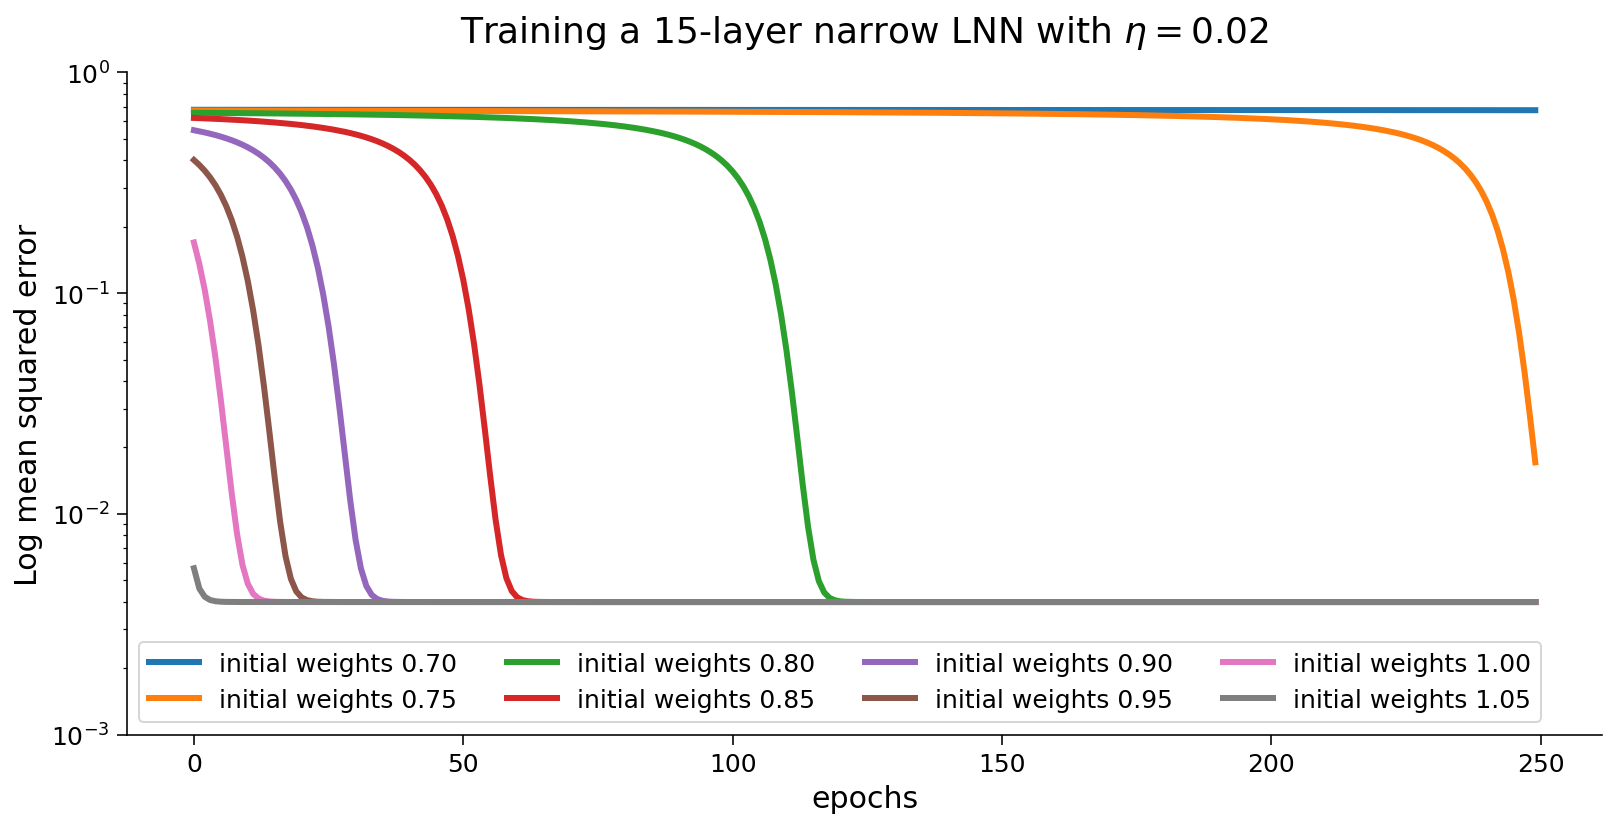

In [37]:
# @markdown Make sure you execute this cell to see the figure!

plot_init_effect()

In [38]:
# @title Video 11: Initialization Matters Explained
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1hM4y1T7gJ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"vKktGdiQDsE", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 11: Initialization Matters Explained')

display(out)

---
# Summary

In the second tutorial, we have learned what is the training landscape, and also we have see in depth the effect of the depth of the network and the learning rate, and their interplay. Finally, we have seen that initialization matters and why we need smart ways of initialization.

In [46]:
# @title Video 12: Tutorial 2 Wrap-up
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1P44y117Pd", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"r3K8gtak3wA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 12: Tutorial 2 Wrap-up')

display(out)

In [47]:

# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )

---
# Bonus

## Hyperparameter interaction

Finally, let's put everything we learned together and find best initial weights and learning rate for a given depth. By now you should have learned the interactions and know how to find the optimal values quickly. If you get `numerical overflow` warnings, don't be discouraged! They are often caused by "exploding" or "vanishing" gradients.

**Think!**

Did you experience any surprising behaviour 
or difficulty finding the optimal parameters?

In [48]:
# @markdown Make sure you execute this cell to enable the widget!

_ = interact(depth_lr_init_interplay,
             depth = IntSlider(min=10, max=51, step=5, value=25,
                               continuous_update=False),
             lr = FloatSlider(min=0.001, max=0.1,
                              step=0.005, value=0.005,
                              continuous_update=False,
                              readout_format='.3f',
                              description='eta'),
             init_weights = FloatSlider(min=0.1, max=3.0,
                                        step=0.1, value=0.9,
                                        continuous_update=False,
                                        readout_format='.3f',
                                        description='initial weights'))

interactive(children=(IntSlider(value=25, continuous_update=False, description='depth', max=51, min=10, step=5…